## Import modules, packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sci-kit learn specifics
# We will use the sklearn package to obtain ridge regression and lasso models.
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import zero_one_loss, confusion_matrix, roc_auc_score, roc_curve, make_scorer

## Load the pre-processed `Loan` data set

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146775 entries, 0 to 146774
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              146775 non-null  float64
 1   term                   146775 non-null  object 
 2   int_rate               146775 non-null  float64
 3   sub_grade              146775 non-null  object 
 4   emp_length             146775 non-null  object 
 5   home_ownership         146775 non-null  object 
 6   annual_inc             146775 non-null  float64
 7   verification_status    146775 non-null  object 
 8   loan_status            146775 non-null  int64  
 9   purpose                146775 non-null  object 
 10  addr_state             146775 non-null  object 
 11  dti                    146775 non-null  float64
 12  delinq_2yrs            146775 non-null  float64
 13  earliest_cr_line       146775 non-null  int64  
 14  inq_last_6mths         146775 non-nu

## Recoding the categorical variables

In [4]:
# generate list of remaining categorical features
obcols = list(df.columns[df.dtypes == 'object'])
obcols

['term',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status']

In [5]:
for col in obcols:
    print(df[col].value_counts())

 36 months    116160
 60 months     30615
Name: term, dtype: int64
B5    10375
C1    10346
B4     9599
C2     8870
B3     8696
C4     8370
C3     8223
B2     7960
B1     7917
C5     7561
A1     6740
A5     5560
D1     5263
A4     5002
D2     4941
A2     3729
D3     3687
D4     3603
A3     3530
D5     2908
E1     2670
E3     1866
E2     1847
E4     1610
E5     1371
F1     1064
F2      812
F3      612
F4      552
F5      474
G1      314
G2      246
G3      198
G4      145
G5      114
Name: sub_grade, dtype: int64
10+ years    49623
< 1 year     20606
2 years      13661
3 years      12009
1 year       10076
5 years       9018
4 years       8743
8 years       6421
6 years       6127
9 years       5738
7 years       4753
Name: emp_length, dtype: int64
MORTGAGE    71423
RENT        57610
OWN         17708
ANY            34
Name: home_ownership, dtype: int64
Source Verified    61685
Verified           43156
Not Verified       41934
Name: verification_status, dtype: int64
debt_consolidation   

In [6]:
# convert term to int (either 36 or 60)
df['term'] = list(map(lambda t: int(str(t)[0:3]), df['term']))


# emp_length map from 0 to 10 (< 1 -> 0 and 10+ -> 10)
def map_emp_length(emp_length):
    temp = str(emp_length)[0:2]
    if temp == '< ':
        temp = '0'
    if temp == 'na':
        temp = '0'
    return int(temp)


df['emp_length'] = list(map(map_emp_length, df['emp_length']))

# convert initial_list_status to numerical (dummy) values
mapping_dictionary = {'initial_list_status': {'w': 1, 'f': 0}}
df = df.replace(mapping_dictionary)

# convert home_ownership using one-hot encoding
home_encoding = pd.get_dummies(df['home_ownership'])
df = pd.concat([df, home_encoding], axis=1)
df.drop('home_ownership', axis=1, inplace=True)

# convert verification_status using one-hot encoding
verification_status = pd.get_dummies(df['verification_status'])
df = pd.concat([df, verification_status], axis=1)
df.drop('verification_status', axis=1, inplace=True)

# convert purpose using one-hot encoding
purpose = pd.get_dummies(df['purpose'])
df = pd.concat([df, purpose], axis=1)
df.drop('purpose', axis=1, inplace=True)

# convert sub_grade using consecutive integers
# (as there is a ranking between the values G5 -> A1)
mapping = {'A': 0, 'B': 5, 'C': 10, 'D': 15, 'E': 20, 'F': 25, 'G': 30}
df['sub_grade'] = list(map(lambda t: mapping[t[0]] + int(t[1]), df['sub_grade']))

# convert addr_state using one-hot encoding
addr_state = pd.get_dummies(df['addr_state'])
df = pd.concat([df, addr_state], axis=1)
df.drop('addr_state', axis=1, inplace=True)

df.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_length',
       'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       ...
       'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', length=117)

# Save the updated data set

In [7]:
df.to_csv("numerical_data.csv")

## Scale the data

In [8]:
# drop 60% of the paid out loans so that there is
# a balance between them and the default ones
# drop_paid_out_loans = df[df['loan_status'] == 1]
# subset_paid_out_loans = drop_paid_out_loans.sample(frac=0.6)
# df = df.drop(subset_paid_out_loans.index)
# df.shape

In [9]:
numerical_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numerical_cols.remove("loan_status")

scaler = StandardScaler()
scaler.fit(df[numerical_cols])
df[numerical_cols] = scaler.transform(df[numerical_cols])
df.shape

(146775, 117)

## Split the data set into training and test set

In [10]:
# get "loan status"
y = df["loan_status"]
# drop "loan status"
df.drop("loan_status", axis=1, inplace=True)

# split data into training and test sets (80% - 20%)
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
freq = y_test.value_counts()
freq / sum(freq) * 100

1    76.552546
0    23.447454
Name: loan_status, dtype: float64

## Cross validation to find optimal hyper parameters

In [11]:
# Helper functions
def map_predictions(predictions, threshold):
    result = []
    for p in predictions:
        if p >= threshold:
            result.append(1)
        else:
            result.append(0)
    return result

Optimal alpha (lasso): 0.0001


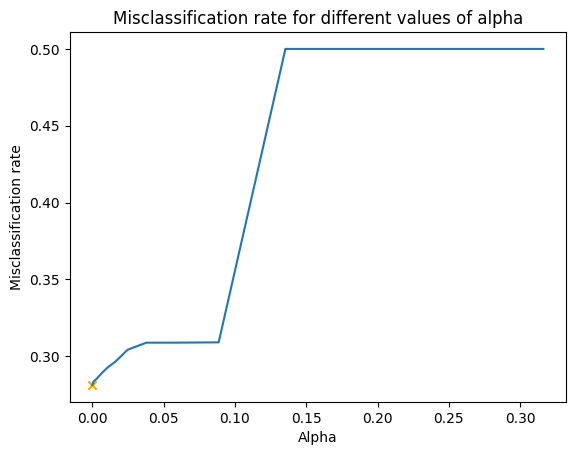

In [12]:
# Lasso
alphas = np.logspace(-4, -0.5, 20)
lasso = Lasso()
grid_search = GridSearchCV(estimator=lasso,
                           param_grid={'alpha': alphas},
                           cv=5,
                           scoring=make_scorer(roc_auc_score, greater_is_better=True))
grid_search.fit(x_train, y_train)

alpha_lasso = grid_search.best_params_['alpha']
print(f"Optimal alpha (lasso): {alpha_lasso}")

plt.plot(alphas, 1 - grid_search.cv_results_['mean_test_score'])
plt.scatter(alpha_lasso, 1 - grid_search.cv_results_['mean_test_score'][np.where(alphas == alpha_lasso)],
            color='orange', marker='x')
plt.title("Misclassification rate for different values of alpha")
plt.xlabel("Alpha")
plt.ylabel("Misclassification rate")
plt.show()

Optimal lambda (ridge): 145.63484775012444


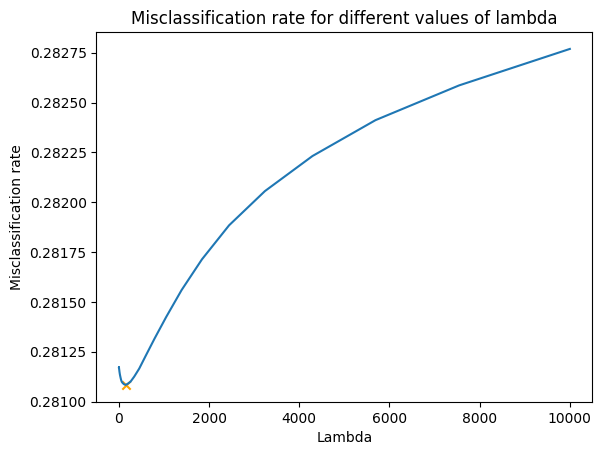

In [13]:
# Ridge
lambdas = np.logspace(-2, 4, 50)
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge,
                           param_grid={'alpha': lambdas},
                           cv=5,
                           scoring=make_scorer(roc_auc_score, greater_is_better=True))
grid_search.fit(x_train, y_train)

lambda_ridge = grid_search.best_params_['alpha']
print(f"Optimal lambda (ridge): {lambda_ridge}")

plt.plot(lambdas, 1 - grid_search.cv_results_['mean_test_score'])
plt.scatter(lambda_ridge, 1 - grid_search.cv_results_['mean_test_score'][np.where(lambdas == lambda_ridge)],
            color='orange', marker='x')
plt.title("Misclassification rate for different values of lambda")
plt.xlabel("Lambda")
plt.ylabel("Misclassification rate")
plt.show()

## Train the actual models using the optimized hyper parameters and pick optimal threshold

In [17]:
# Lasso
lasso = Lasso(alpha=alpha_lasso)
lasso.fit(x_train, y_train)
y_pred_lasso = lasso.predict(x_test)
# Ridge
ridge = Ridge(alpha=lambda_ridge)
ridge.fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)
# Elastic net
model = ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], n_alphas=20, cv=5)
model.fit(x_train, y_train)
print(f"Optimal l1 ratio: {model.l1_ratio_}")
print(f"Optimal alpha (elastic): {model.alpha_}")
elastic = ElasticNet(alpha=model.alpha_)
elastic.fit(x_train, y_train)
y_pred_elastic = elastic.predict(x_test)

Optimal l1 ratio: 0.9
Optimal alpha (elastic): 0.00013553966289060556


In [15]:
print(x_train.columns[np.argsort(np.abs(lasso.coef_))[::-1][:21]])
print(x_train.columns[np.argsort(np.abs(ridge.coef_))[::-1][:21]])
print(x_train.columns[np.argsort(np.abs(elastic.coef_))[::-1][:21]])

Index(['small_business', 'int_rate', 'OR', 'LA', 'AL', 'AR', 'CO', 'UT', 'MD',
       'term', 'WA', 'RENT', 'CT', 'num_actv_rev_tl', 'DC', 'NH', 'ME',
       'medical', 'OK', 'MS', 'num_rev_accts'],
      dtype='object')
Index(['small_business', 'int_rate', 'LA', 'AL', 'AR', 'OR', 'MD', 'DC', 'UT',
       'ME', 'VT', 'CO', 'MS', 'term', 'OK', 'num_rev_accts', 'NH', 'WA', 'ND',
       'CT', 'num_actv_rev_tl'],
      dtype='object')
Index(['small_business', 'int_rate', 'OR', 'LA', 'AL', 'AR', 'UT', 'CO', 'DC',
       'MD', 'term', 'ME', 'WA', 'CT', 'NH', 'VT', 'RENT', 'num_actv_rev_tl',
       'MS', 'medical', 'OK'],
      dtype='object')


Threshold: 0.1
Confusion matrix (lasso):
[[ 0.   23.45]
 [ 0.   76.55]]
Threshold: 0.1
Confusion matrix (ridge):
[[ 0.   23.45]
 [ 0.   76.55]]
Threshold: 0.1
Confusion matrix (elastic):
[[ 0.   23.45]
 [ 0.   76.55]]
Threshold: 0.2
Confusion matrix (lasso):
[[0.000e+00 2.345e+01]
 [1.000e-02 7.655e+01]]
Threshold: 0.2
Confusion matrix (ridge):
[[0.000e+00 2.345e+01]
 [1.000e-02 7.654e+01]]
Threshold: 0.2
Confusion matrix (elastic):
[[0.000e+00 2.345e+01]
 [1.000e-02 7.655e+01]]
Threshold: 0.3
Confusion matrix (lasso):
[[4.000e-02 2.341e+01]
 [4.000e-02 7.651e+01]]
Threshold: 0.3
Confusion matrix (ridge):
[[4.000e-02 2.341e+01]
 [4.000e-02 7.651e+01]]
Threshold: 0.3
Confusion matrix (elastic):
[[4.000e-02 2.341e+01]
 [4.000e-02 7.652e+01]]
Threshold: 0.4
Confusion matrix (lasso):
[[ 0.55 22.9 ]
 [ 0.35 76.2 ]]
Threshold: 0.4
Confusion matrix (ridge):
[[ 0.56 22.89]
 [ 0.35 76.2 ]]
Threshold: 0.4
Confusion matrix (elastic):
[[ 0.55 22.9 ]
 [ 0.35 76.2 ]]
Threshold: 0.5
Confusion matrix 

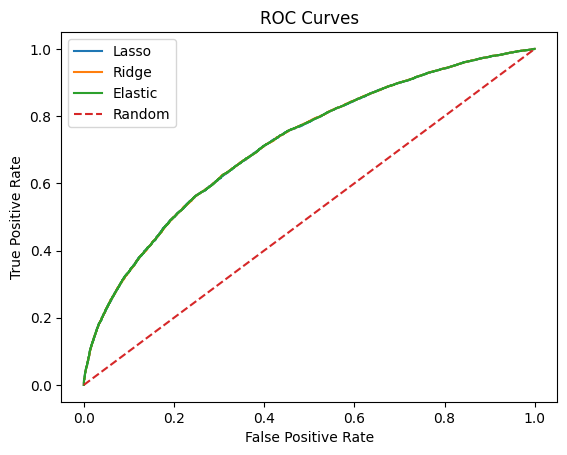

AUC (lasso): 0.7168872318263451
AUC (ridge): 0.7169864723127188
AUC (elastic): 0.7169696046626245


In [16]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    conf_lasso = np.around((confusion_matrix(y_test, map_predictions(y_pred_lasso, threshold)) / len(y_test)) * 100, 2)
    print("Threshold:", threshold)
    print("Confusion matrix (lasso):")
    print(conf_lasso)

    conf_ridge = np.around((confusion_matrix(y_test, map_predictions(y_pred_ridge, threshold)) / len(y_test)) * 100, 2)
    print("Threshold:", threshold)
    print("Confusion matrix (ridge):")
    print(conf_ridge)

    conf_elastic = np.around((confusion_matrix(y_test, map_predictions(y_pred_elastic, threshold)) / len(y_test)) * 100,
                             2)
    print("Threshold:", threshold)
    print("Confusion matrix (elastic):")
    print(conf_elastic)

fp_lasso, tp_lasso, _ = roc_curve(y_test, y_pred_lasso)
fp_ridge, tp_ridge, _ = roc_curve(y_test, y_pred_ridge)
fp_elastic, tp_elastic, _ = roc_curve(y_test, y_pred_elastic)

plt.plot(fp_lasso, tp_lasso, label='Lasso')
plt.plot(fp_ridge, tp_ridge, label='Ridge')
plt.plot(fp_elastic, tp_elastic, label='Elastic')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

auc = roc_auc_score(y_test, y_pred_lasso)
print("AUC (lasso):", auc)

auc = roc_auc_score(y_test, y_pred_ridge)
print("AUC (ridge):", auc)

auc = roc_auc_score(y_test, y_pred_elastic)
print("AUC (elastic):", auc)